In [1]:
import scipy
import numpy as np
import pandas as pd
from hedge_class import hedge_pricer
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math
import copy
import warnings
warnings.filterwarnings("ignore")
sns.set()

### Read in Data, set up pricer object

Refer to hedge_class.py for the library used for calculations

In [9]:
CF_DF=pd.read_excel("Data/Quantitative Analyst Case Study 2021 - Cashflow Model (1).xlsx",parse_dates=[0])
CF_DF.Date=[*map(lambda x: x.date(),CF_DF.Date)]
CF_DF['Cashflow Amount (in Local Asset Currecny)']

n_paths=500
n_assets=1
r_drifts=[0]#[0,0]
sigma_vec=[.1]#[.1,.2]
spot=[1.3925]#[1.3925,1.3]
dt=1
total_time=5

CF={i:np.array([CF_DF['Cashflow Amount (in Local Asset Currecny)'][i]]) for i in range(total_time+1)}

corr=1
seed=0
hp=hedge_pricer(n_paths=n_paths,n_assets=n_assets,r_drifts=r_drifts,sigma_vec=sigma_vec,spot=spot,dt=dt,total_time=total_time,CF=CF,corr=corr,seed=seed)


### Part a

The model used here is:

$dS_t = r_{drift}*S_t*dt +\sigma*S_t*dW_t$ 

$r_{drift}=r_{USD}-r_{GBP}=0,\sigma=.1$

$S_t=X_{\frac{GBP}{USD}}$=GBPUSD Spot

GBP is essentially an asset denoted in USD here. We show the 1000 paths of the GBPUSD spot below over 5 years.

[Text(0,0,'0'),
 Text(0,0,'0'),
 Text(0,0,'1'),
 Text(0,0,'2'),
 Text(0,0,'3'),
 Text(0,0,'4'),
 Text(0,0,'5')]

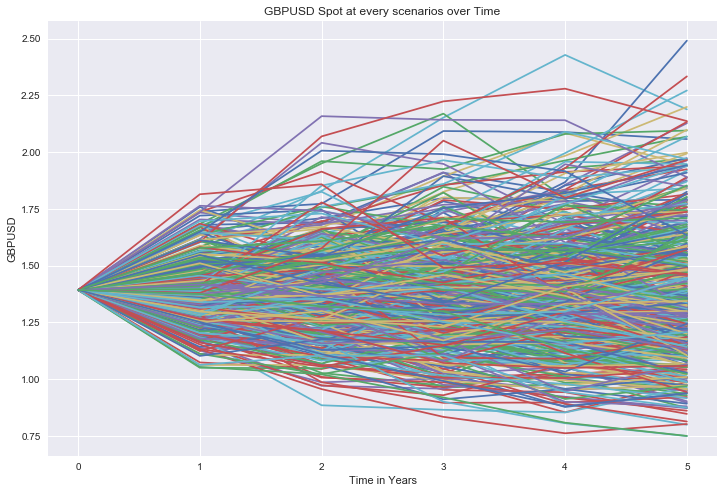

In [3]:
hp_paths=hp.ret_paths()
all_scen_paths_DF=pd.DataFrame(hp_paths.T[0])
ax=all_scen_paths_DF.iloc[::1].T.plot(figsize=(12,8),legend=None)
ax.set_xlabel("Time in Years")
ax.set_ylabel("GBPUSD")
ax.set_title('GBPUSD Spot at every scenarios over Time')
ax.set_xticklabels([0]+list(range(total_time+1)))

### Part b

For every scenario, we calculate the IRR to equate to 0 NPV of the CFs in the scenario. We show the IRRs distribution below along with key percentiles


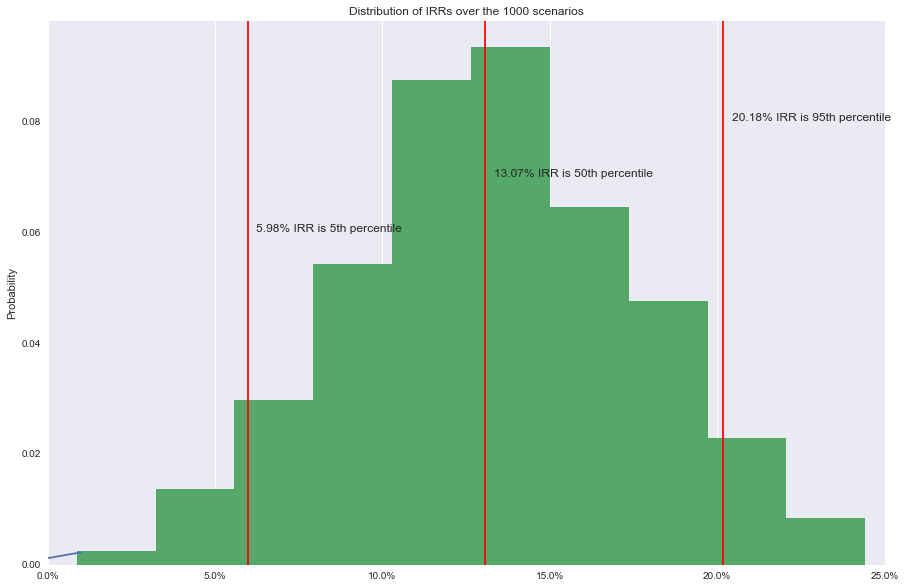

In [4]:
hp_CF_paths=hp.ret_CF(CF)
IRRs=[hp.solve_IRR(hp_CF_paths.T[0][i])*100 for i in range(n_paths)]

dist=pd.Series(IRRs)
fig, ax = plt.subplots(figsize=(15,10))
dist.plot.kde(ax=ax, legend=False, title='Distribution of IRRs over the 1000 scenarios',ind=[0,1])
dist.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_xlim([math.floor(min(IRRs)),math.ceil(max(IRRs))])
v=0
for percentile in [5,50,95]:
    v+=.01
    pct=np.percentile(IRRs, percentile)
    plt.axvline(x=pct, ymin=0, ymax=1,color='r')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

    plt.text(pct+.25, max(ax.get_yticks())/2+v, '{0} IRR is {1}th percentile'.format("{:.2%}".format(pct/100),percentile), fontsize=12)

### Part c

Since for every scenario we have the ending GBPUSD spot, we use that to value the option per every scenario as $N*max(K-X^T_{GBPUSD}),0)$ at every scenario. We ten discount every scenario's payoff by the forward rate, which here is 0 as $r_{USD}=r_{GBP}$

$Option PriceInUSD=\sum_{i=1}^{1000}{\frac{N*max(K-X^{T_i}_{GBPUSD},0)}{e^{r_{fwd}*T}}}=$ $12,624,277.98

$T = 5$ = length of option, K=1.3925, i is $i^{th} scenario$, N=100,000,000 GBP

$X^{T_i}_{GBPUSD}$ can be observed from the paths we generated in Part a)

In [5]:

r_usd=0
r_gbp=0
r_fwd=r_usd-r_gbp
K=1.3925
T=5
N=100000000
    
option_cost=hp.option_calc_put(r_fwd,K,T,N,index=0) ## Answer in USD
option_cost

12624277.978257032

### Part d
Upon adding the Cashflows observed by the option in every path to the CF path we generated in part b, we re-run the IRRs. We then plot them.

We primarily see a lognormal type distribution as opposed to a normal distribution as in part b. This makes sense as a large part of the cash recieved has been hedged essentially putting a floor on the IRR we would observe.

In [6]:
## Assuming cash is converted to USD right away


K=1.3925
T=5
N=100000000
index=0
option_payoff_all_scen=[]
for i in range(len(hp_paths.T[index])):
    scen=hp_paths.T[index][i]
    option_payoff=[0]*(T)+[max((K-scen[T])*N,0)]
    option_payoff_disc=[math.exp(-r_fwd*i)*option_payoff[i] for i in range(T+1)]
    option_payoff[0]=-option_cost
    option_payoff_all_scen.append(option_payoff)
    
option_payoff_all_scen=np.array(option_payoff_all_scen)

hp_hedged_CF_paths=copy.deepcopy(hp_CF_paths)
hp_hedged_CF_paths.T[0]=(hp_hedged_CF_paths.T[0]+option_payoff_all_scen)


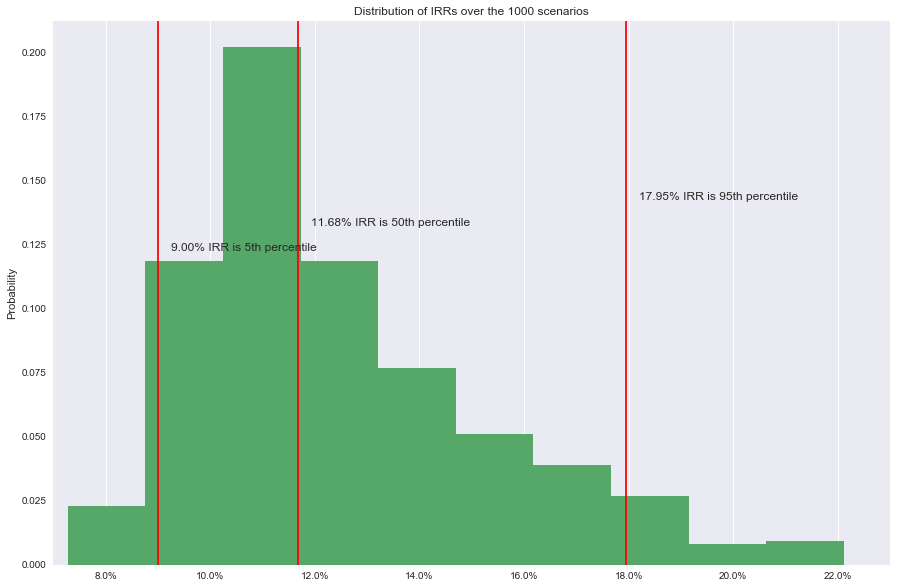

In [7]:
IRRs=[hp.solve_IRR(hp_hedged_CF_paths.T[0][i])*100 for i in range(n_paths)]

dist=pd.Series(IRRs)
fig, ax = plt.subplots(figsize=(15,10))
dist.plot.kde(ax=ax, legend=False, title='Distribution of IRRs over the 1000 scenarios',ind=[0,1])
dist.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_xlim([math.floor(min(IRRs)),math.ceil(max(IRRs))])
v=0
for percentile in [5,50,95]:
    v+=.01
    pct=np.percentile(IRRs, percentile)
    plt.axvline(x=pct, ymin=0, ymax=1,color='r')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

    plt.text(pct+.25, max(ax.get_yticks())/2+v, '{0} IRR is {1}th percentile'.format("{:.2%}".format(pct/100),percentile), fontsize=12)